In [ ]:
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np
import os
from tqdm import tqdm

def get_dominant_colors(image_path, k=5):
    img = Image.open(image_path).convert("RGB").resize((300, 300))
    pixels = np.array(img).reshape(-1, 3)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pixels)
    return kmeans.cluster_centers_.astype(int)

frame_dirs = ['study_me_frames', 
              'cream_frames',
              'kuzuri_frames', 
              'hippo_pain_frames', 
              'truth_in_lies_frames', 
              'mirror_tune_frames', 
              'milabo_frames', 
              'time_left_frames',
              'hanaichi_frames', 
              'inside_joke_frames', 
              'justice_frames', 
              'kira_killer_frames', 
              'shade_frames']

mv_frame_centroids = []
mv_colors = []

for frame_dir in frame_dirs:
    frame_centroids = []
    all_colors = []

    for fname in tqdm(sorted(os.listdir(frame_dir))):
        path = os.path.join(frame_dir, fname)
        try:
            colors = get_dominant_colors(path, k=7)
            avg_color = np.mean(colors, axis=0)
            frame_centroids.append((avg_color, path))
            all_colors.extend(colors)
        except:
            continue

    mv_frame_centroids.append(frame_centroids)
    mv_colors.append(all_colors)

In [506]:
def reduce_palette(colors, final_k=12):
    kmeans = KMeans(n_clusters=final_k, random_state=1).fit(colors)
    return kmeans.cluster_centers_.astype(int)

final_palettes = []
for all_colors in mv_colors:
    palette = reduce_palette(all_colors, final_k=10)
    final_palettes.append(palette)

In [507]:
def get_representative_frames(frame_centroids, num_clusters=5):

    def brightness(rgb):
        # Perceived luminance formula
        return 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
    
    filtered = [(c, p) for (c, p) in frame_centroids if (brightness(c) > 80) & (brightness(c) < 170)]

    if len(filtered) < num_clusters:
        filtered = frame_centroids
        
    colors = np.array([fc[0] for fc in filtered])
    paths = [fc[1] for fc in filtered]

    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    labels = kmeans.fit_predict(colors)

    representatives = []
    
    for cluster_idx in range(0, num_clusters):
        # Get all indices in this cluster
        indices = np.where(labels == cluster_idx)[0]
        cluster_colors = colors[indices]
        cluster_paths = [paths[i] for i in indices]
        center = kmeans.cluster_centers_[cluster_idx]

        # Find the closest frame to the cluster center
        dists = np.linalg.norm(cluster_colors - center, axis=1)
        closest_idx = indices[np.argmin(dists)]
        representatives.append(paths[closest_idx])

    return representatives

mv_repr_paths = []
for i in range(0, len(final_palettes)):
    repr_paths = get_representative_frames(mv_frame_centroids[i], num_clusters=5)
    mv_repr_paths.append(repr_paths)

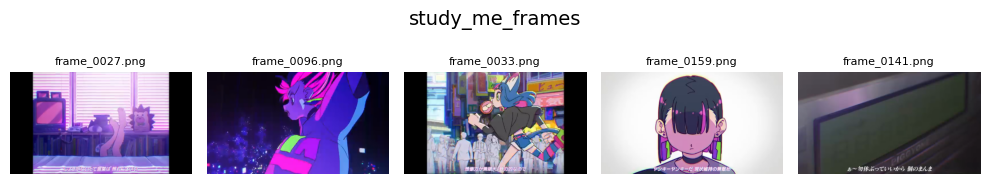

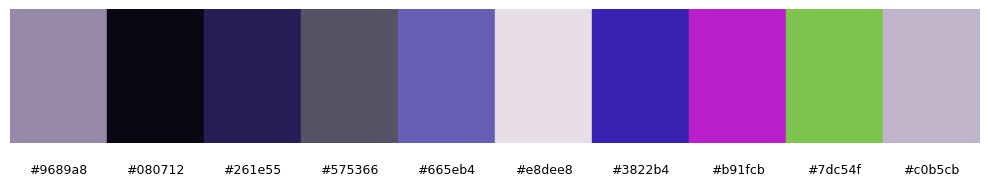

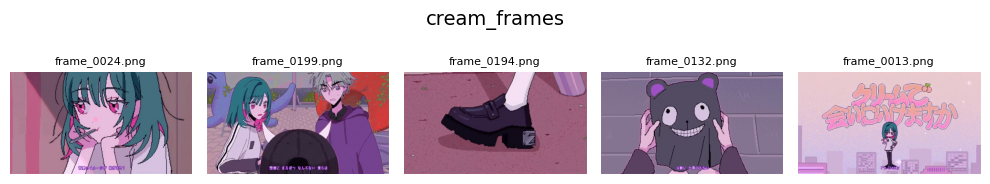

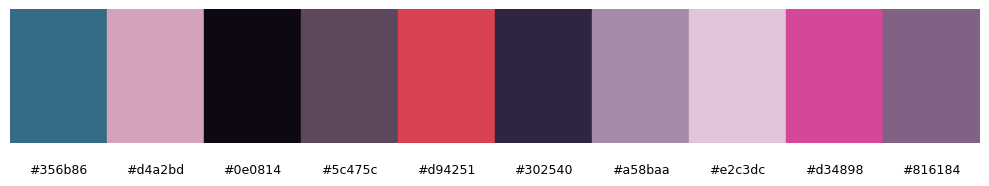

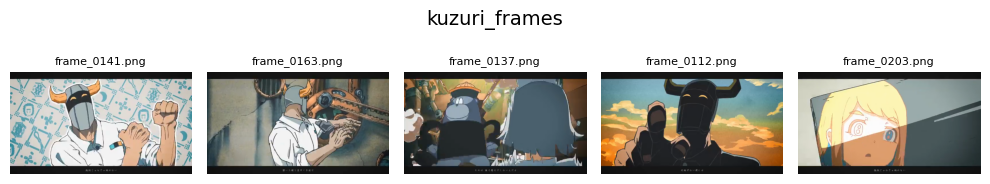

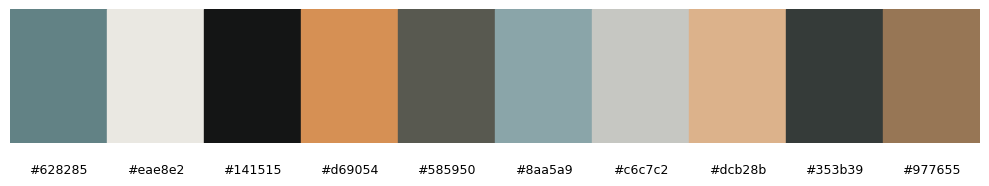

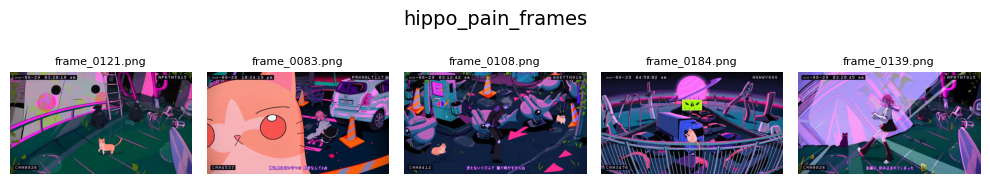

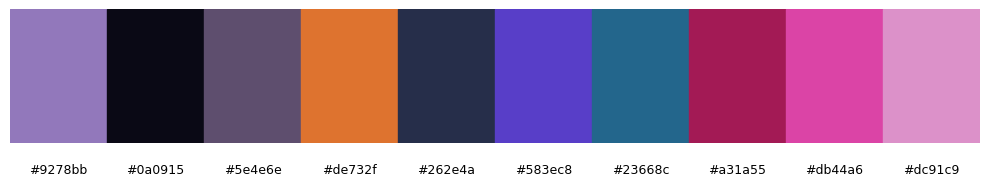

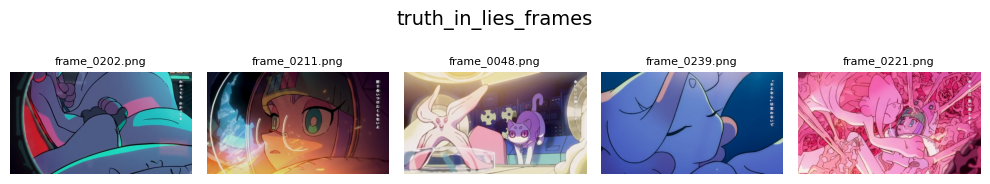

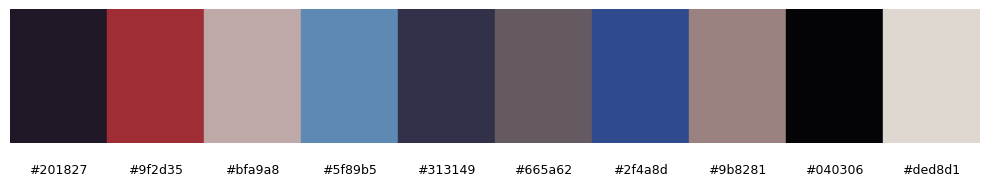

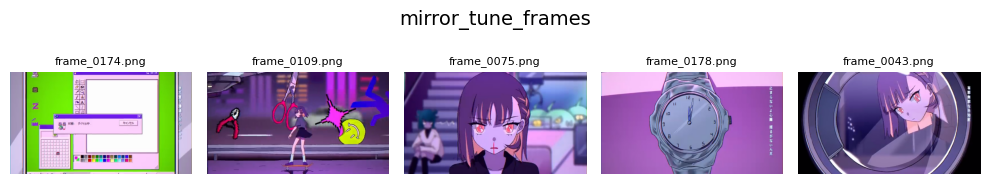

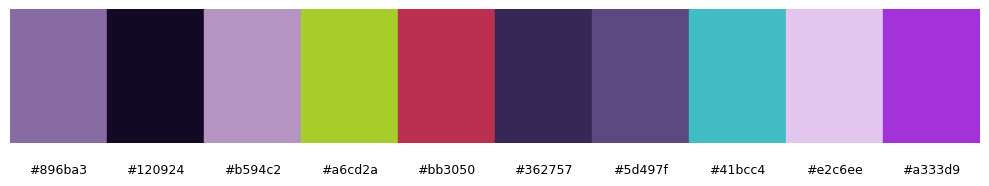

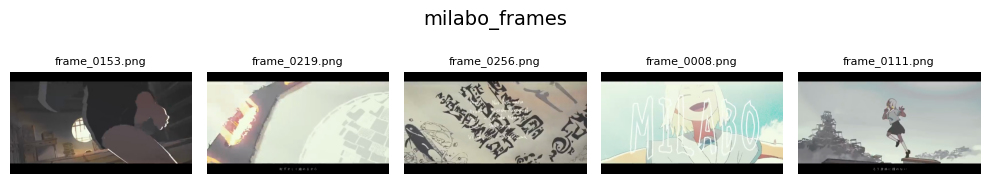

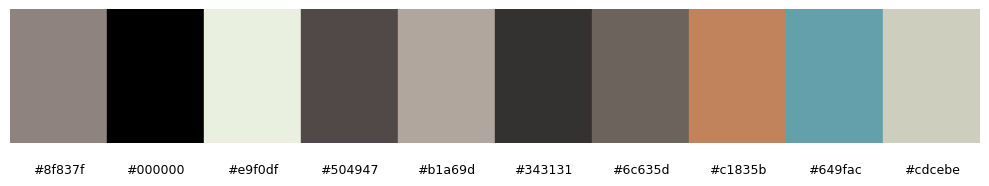

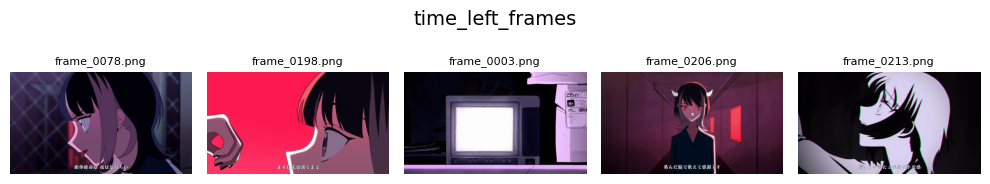

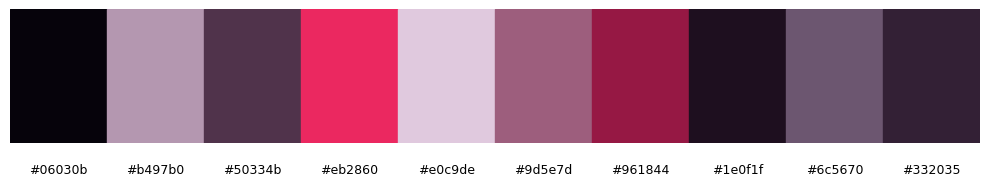

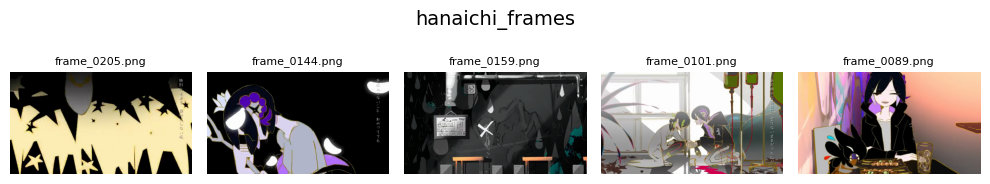

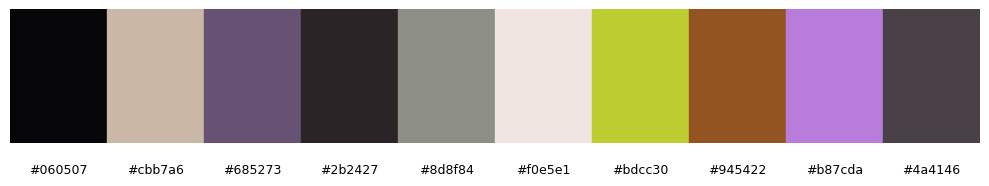

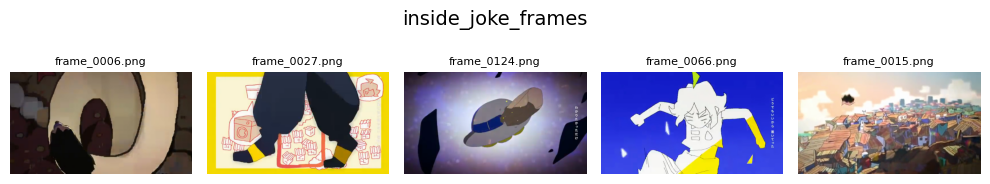

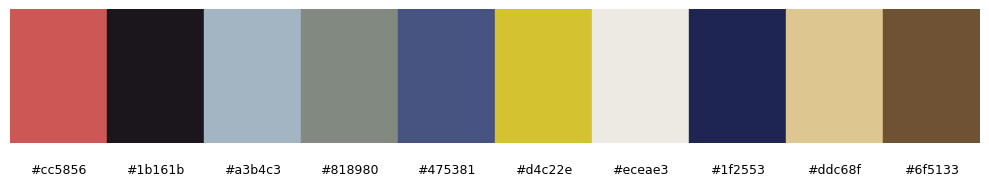

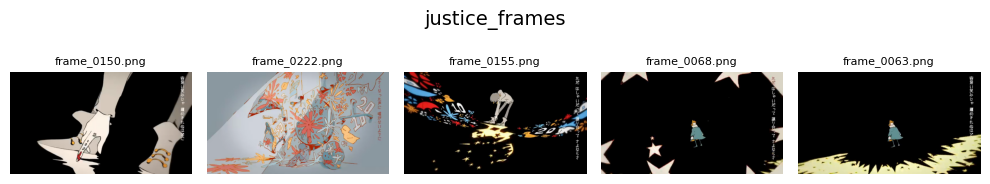

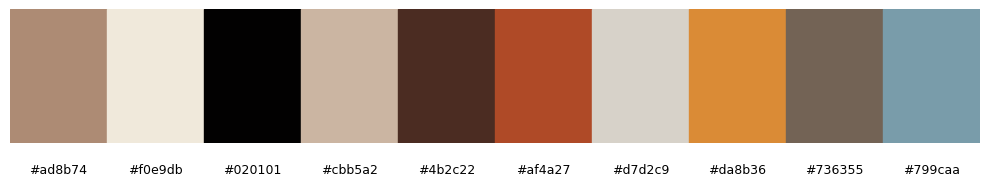

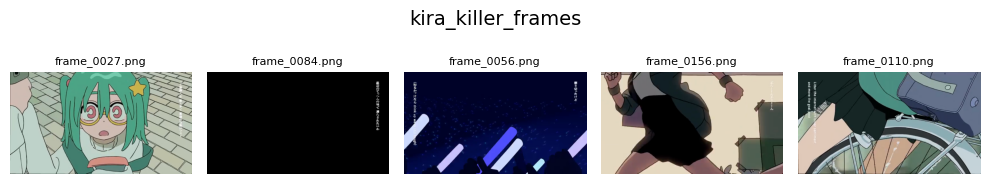

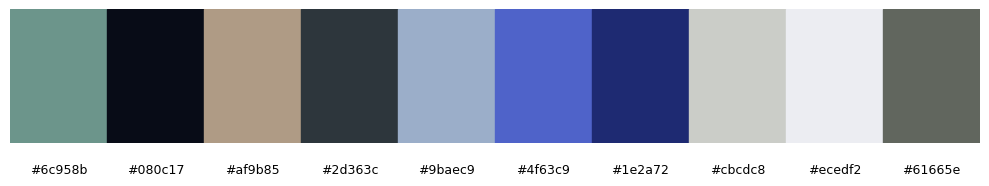

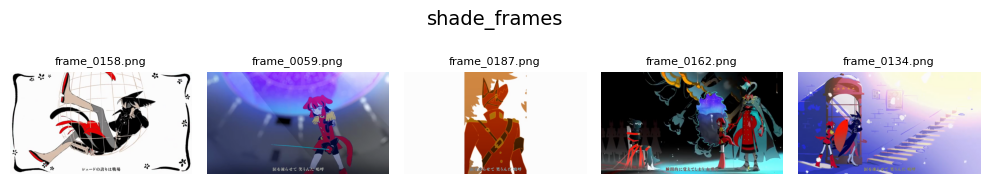

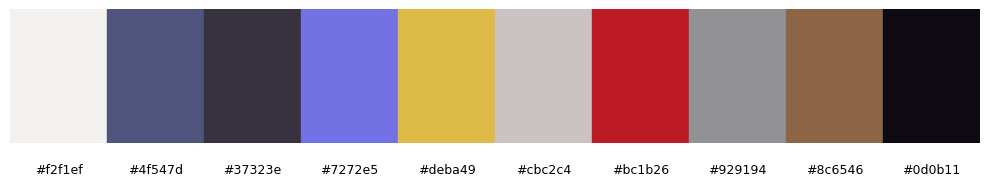

In [508]:
import matplotlib.pyplot as plt

def plot_palette(palette):
    swatch_size = 100
    n = len(palette)
    fig, ax = plt.subplots(figsize=(n, 2))
    
    for i, color in enumerate(palette):
        rgb = tuple(int(c) for c in color)
        hex_val = '#%02x%02x%02x' % rgb
        rect = plt.Rectangle((i, 0), 1, 1, color=np.array(rgb)/255)
        ax.add_patch(rect)
        ax.text(i + 0.5, -0.15, str(hex_val), ha='center', va='top', fontsize=9)

    ax.set_xlim(0, n)
    ax.set_ylim(0, 1)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

def display_thumbnails(image_paths, title=None):
    n = len(image_paths)
    fig, axes = plt.subplots(1, n, figsize=(n * 2, 2))

    if title:
        fig.suptitle(title, fontsize=14)

    for ax, img_path in zip(axes, image_paths):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(os.path.basename(img_path), fontsize=8)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

for i in range(0, len(final_palettes)):
    display_thumbnails(mv_repr_paths[i], title=f"{frame_dirs[i]}")
    plot_palette(final_palettes[i])



Merged palette


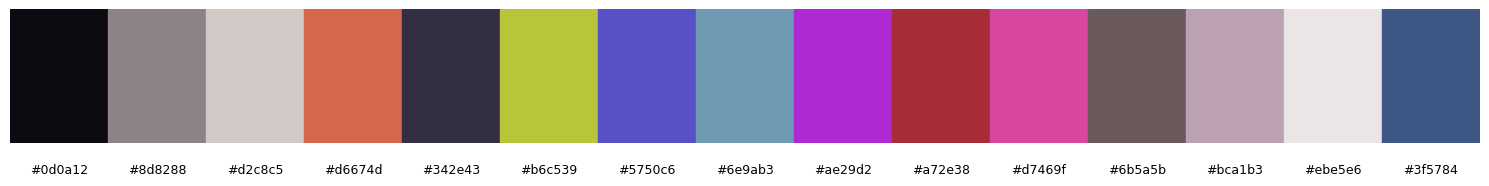

In [509]:
# Flatten all colors into a single list
all_video_colors = np.vstack(final_palettes)

k = 15

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(all_video_colors)
merged_palette = kmeans.cluster_centers_.astype(int)

print("Merged palette")
plot_palette(merged_palette)

In [ ]:
import colorsys
import numpy as np

def rgb_palette_to_hsl(palette_rgb):
    hsl_palette = []
    for r, g, b in palette_rgb:
        h, l, s = colorsys.rgb_to_hls(r/255.0, g/255.0, b/255.0)
        hsl_palette.append((h, s, l))
    return np.array(hsl_palette)

def hsl_to_bin(h, s, l, h_bins=8, s_bins=5, l_bins=3):
    h_idx = min(int(h * h_bins), h_bins - 1)
    s_idx = min(int(s * s_bins), s_bins - 1)
    l_idx = min(int(l * l_bins), l_bins - 1)
    return h_idx * s_bins * l_bins + s_idx * l_bins + l_idx

X = []  # histogram features
y = []  # mv label (from frame dir)

# Form training data from even frames (0, 2, 4, 6...)
# ie we grab a frame every 2 seconds.
for mv_idx, frame_dir in enumerate(frame_dirs):
    full_dir = f"./{frame_dir}"
    all_frames = sorted(os.listdir(full_dir))
    sample_frames = all_frames[::2]

    for fname in sample_frames:
        path = os.path.join(full_dir, fname)
        try:
            dominant_colors = get_dominant_colors(path, k=20)
            hsl_palette = rgb_palette_to_hsl(dominant_colors)

            hist = np.zeros(8 * 5 * 3, dtype=int)
            for h, s, l in hsl_palette:
                bin_index = hsl_to_bin(h, s, l)
                hist[bin_index] += 1
                
            hist = hist / np.sum(hist)
            X.append(hist)
            y.append(frame_dir)
        except:
            continue


In [622]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Try out a few models
    
# clf = DecisionTreeClassifier(max_depth=16)
# clf = LogisticRegression()
for d in range(2, 20):
    clf = RandomForestClassifier(n_estimators=100, max_depth=d)
    score = cross_val_score(clf, X, y, cv=5).mean()
    print(f"Depth {d}: Accuracy = {score:.2%}")
clf = RandomForestClassifier(n_estimators=100, max_depth=12)
clf.fit(X, y)

print(f'\nWe have 13 MVs with about 120 frames each. Total: ~{13 * 120} frames')
print(f'We choose a depth of 12')

Depth 2: Accuracy = 43.98%
Depth 3: Accuracy = 47.65%
Depth 4: Accuracy = 50.28%
Depth 5: Accuracy = 53.94%
Depth 6: Accuracy = 55.90%
Depth 7: Accuracy = 56.63%
Depth 8: Accuracy = 59.62%
Depth 9: Accuracy = 60.35%
Depth 10: Accuracy = 61.51%
Depth 11: Accuracy = 62.12%
Depth 12: Accuracy = 62.00%
Depth 13: Accuracy = 62.49%
Depth 14: Accuracy = 63.22%
Depth 15: Accuracy = 63.16%
Depth 16: Accuracy = 63.77%
Depth 17: Accuracy = 63.59%
Depth 18: Accuracy = 64.81%
Depth 19: Accuracy = 63.77%

We have 13 MVs with about 120 frames each. Total: ~1560 frames
We choose a depth of 12


Testing on uneven (random cropping) screenshot from Milabo


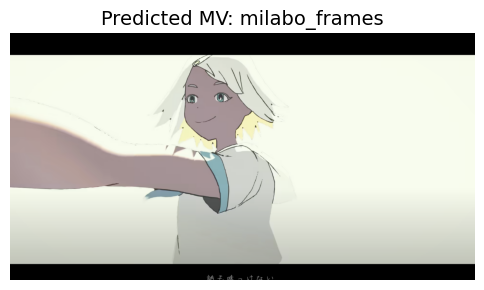

In [623]:
# Test on a screenshotted frame with uneven cropping
frame_path = "test/milabo.png"
dominant_colors = get_dominant_colors(frame_path, k=20)

hsl_palette = rgb_palette_to_hsl(dominant_colors)

frame_hist = np.zeros(8 * 5 * 3, dtype=int)

for h, s, l in hsl_palette:
    bin_index = hsl_to_bin(h, s, l)
    frame_hist[bin_index] += 1
frame_hist = frame_hist / np.sum(frame_hist)

predicted_mv = clf.predict([frame_hist])[0]
img = Image.open(frame_path)
plt.figure(figsize=(6, 4))
plt.imshow(img)

print("Testing on uneven (random cropping) screenshot from Milabo")
plt.title(f"Predicted MV: {predicted_mv}", fontsize=14)
plt.axis('off')
plt.show()
    

In [624]:
import os
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

def predict_frame_path(frame_path):
    dominant_colors = get_dominant_colors(frame_path, k=20)
    hsl_palette = rgb_palette_to_hsl(dominant_colors)
    
    # Bin into histogram
    frame_hist = np.zeros(8 * 5 * 3, dtype=int)
    for h, s, l in hsl_palette:
        bin_index = hsl_to_bin(h, s, l)
        frame_hist[bin_index] += 1
    
    frame_hist = frame_hist / np.sum(frame_hist)
    
    return clf.predict([frame_hist])[0]

y_true = []
y_pred = []
y_paths = []

# Test on the odd frames (1, 25, 49 ...)
for frame_dir in frame_dirs:
    full_dir = f"./{frame_dir}"
    all_frames = sorted(os.listdir(full_dir))
    
    sample_frames = all_frames[1::24]

    for fname in tqdm(sample_frames, desc=f"Evaluating {frame_dir}"):
        frame_path = os.path.join(full_dir, fname)
        try:
            pred = predict_frame_path(frame_path)
            y_pred.append(pred)
            y_true.append(frame_dir)
            y_paths.append(frame_path)
        except Exception as e:
            print(f"Error on {frame_path}: {e}")

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2%}")

Evaluating kira_killer_frames:  91%|██████████▉ | 10/11 [00:02<00:00,  5.30it/s]/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (20). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
Evaluating shade_frames: 100%|██████████████████| 10/10 [00:02<00:00,  4.14it/s]


Classification Report:
                      precision    recall  f1-score   support

        cream_frames       0.75      0.90      0.82        10
     hanaichi_frames       1.00      0.73      0.84        11
   hippo_pain_frames       1.00      0.89      0.94         9
  inside_joke_frames       0.86      0.55      0.67        11
      justice_frames       1.00      1.00      1.00        12
  kira_killer_frames       0.78      0.64      0.70        11
       kuzuri_frames       0.75      0.90      0.82        10
       milabo_frames       0.75      1.00      0.86        12
  mirror_tune_frames       0.82      0.82      0.82        11
        shade_frames       1.00      0.80      0.89        10
     study_me_frames       0.77      0.83      0.80        12
    time_left_frames       0.83      1.00      0.91        10
truth_in_lies_frames       0.77      0.83      0.80        12

            accuracy                           0.84       141
           macro avg       0.85      0.84   

Testing on unseen odd frames


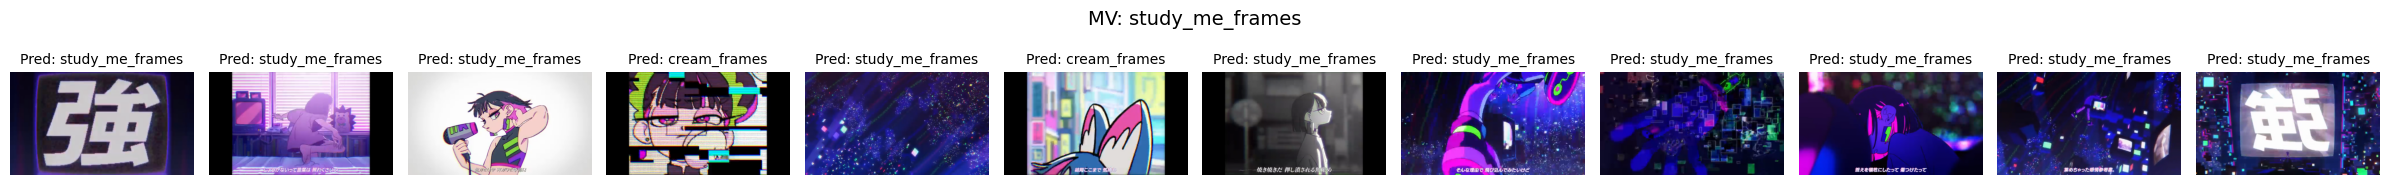

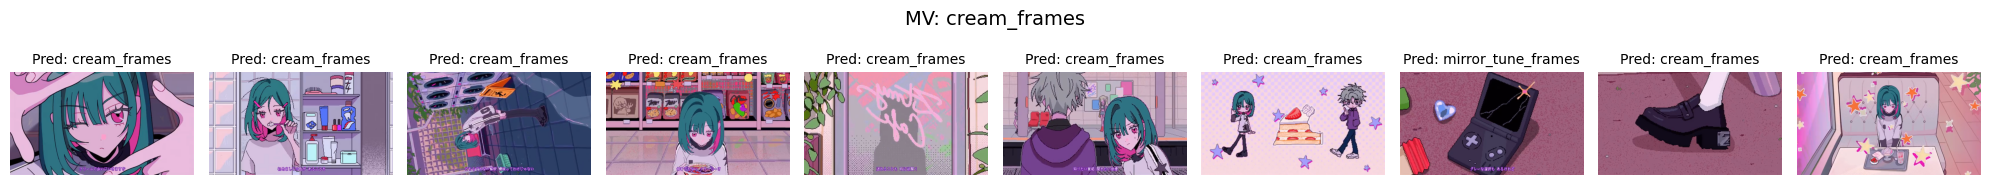

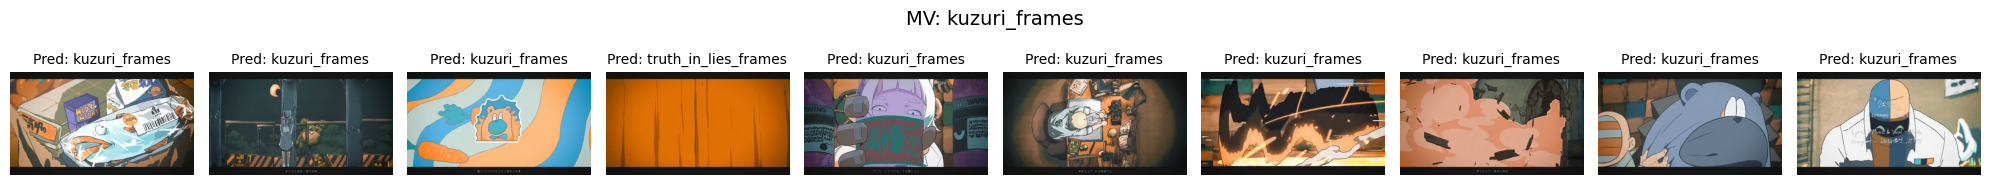

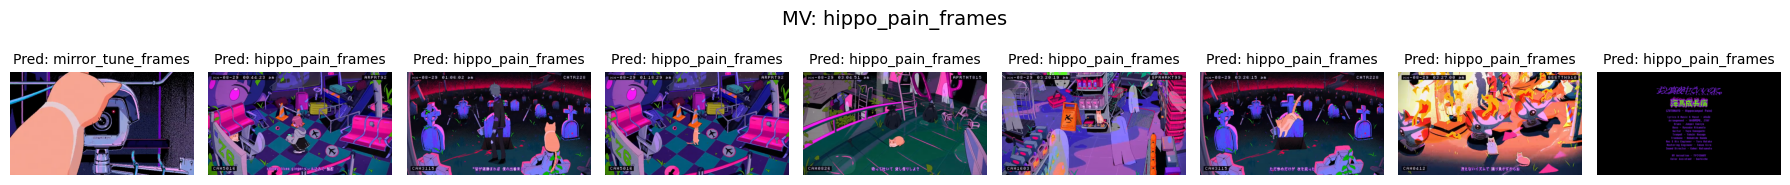

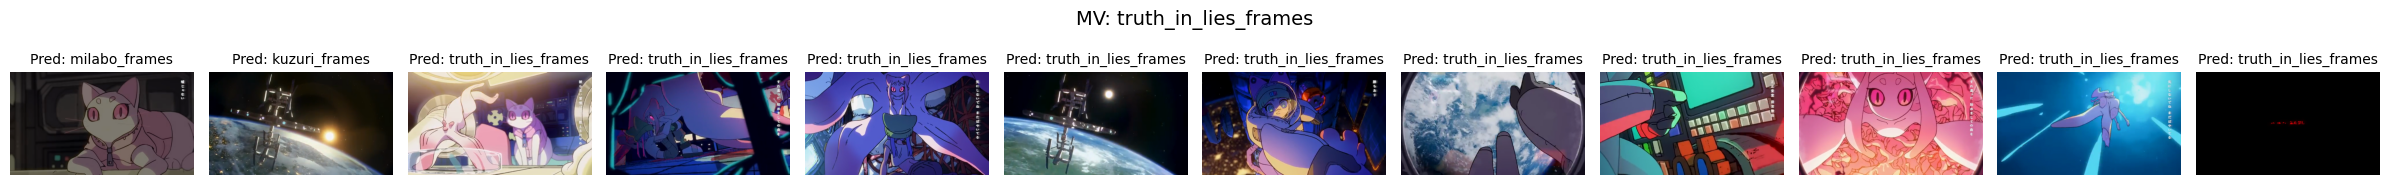

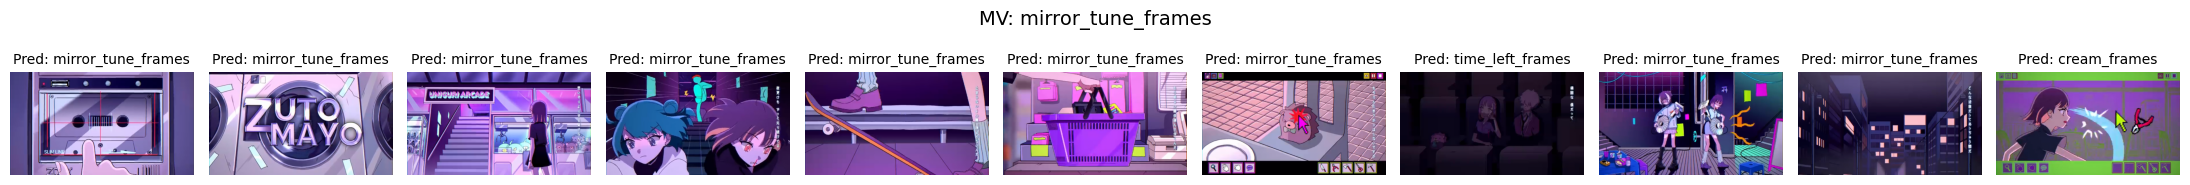

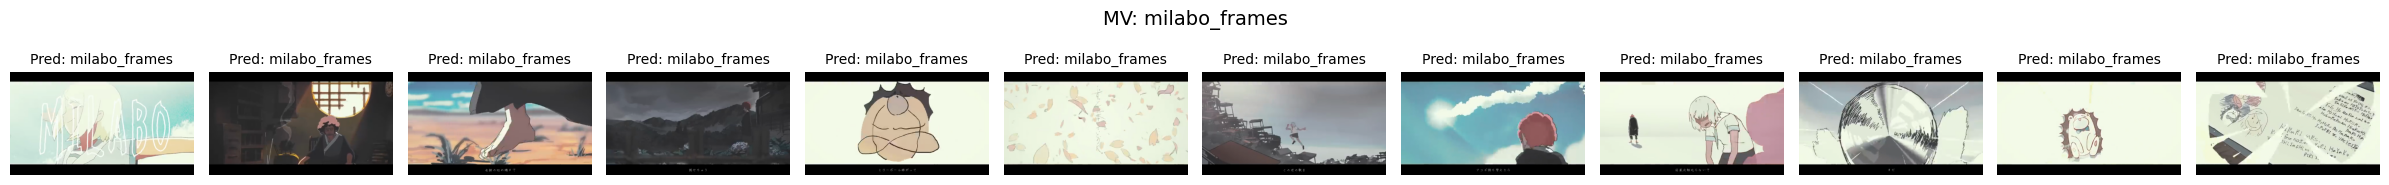

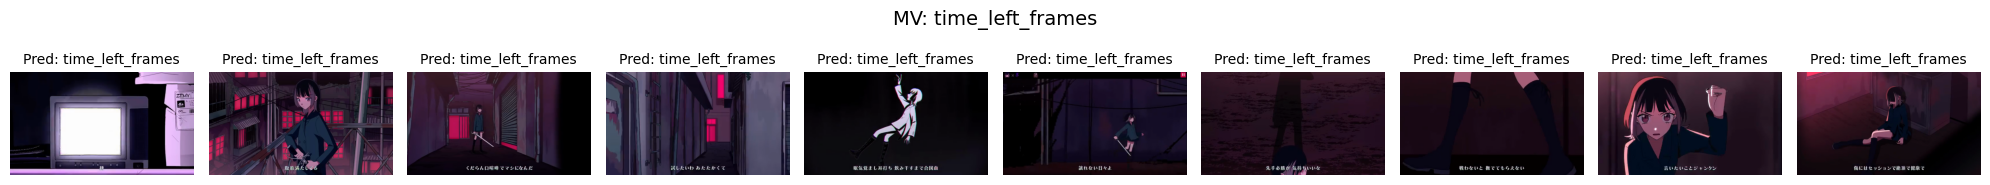

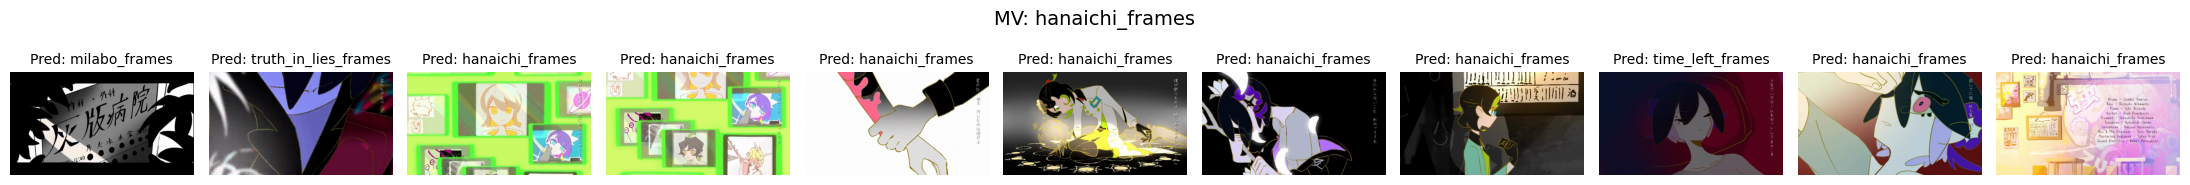

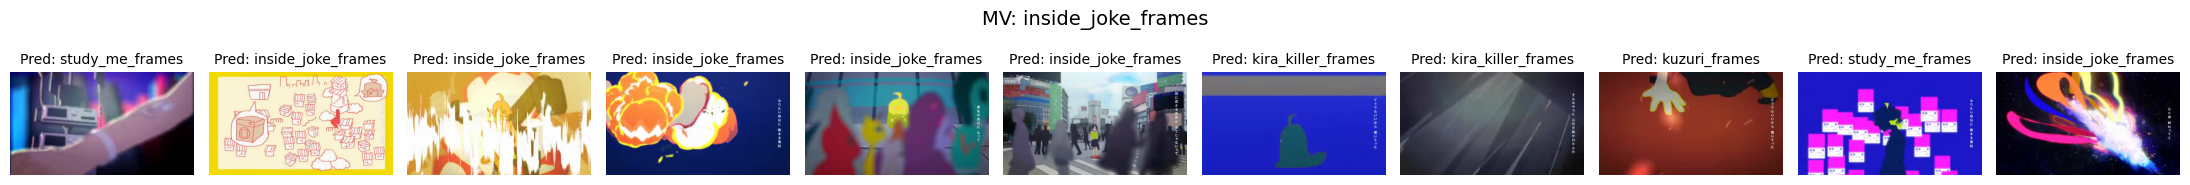

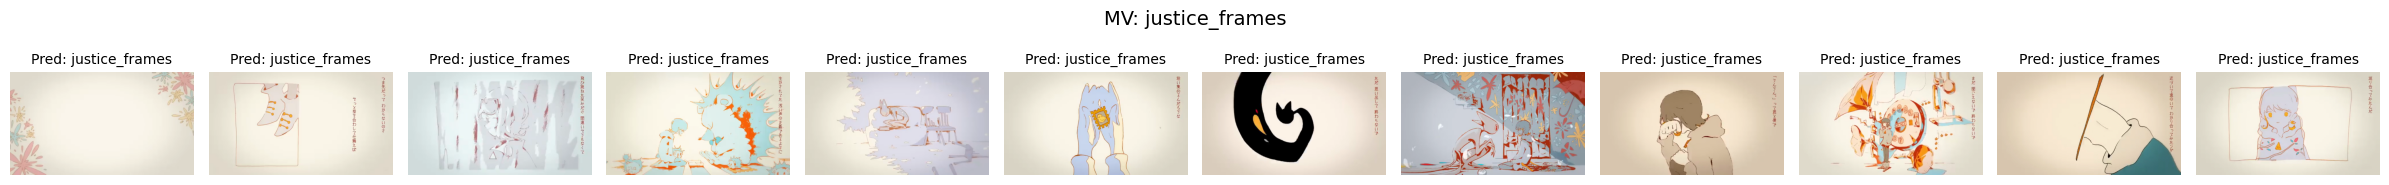

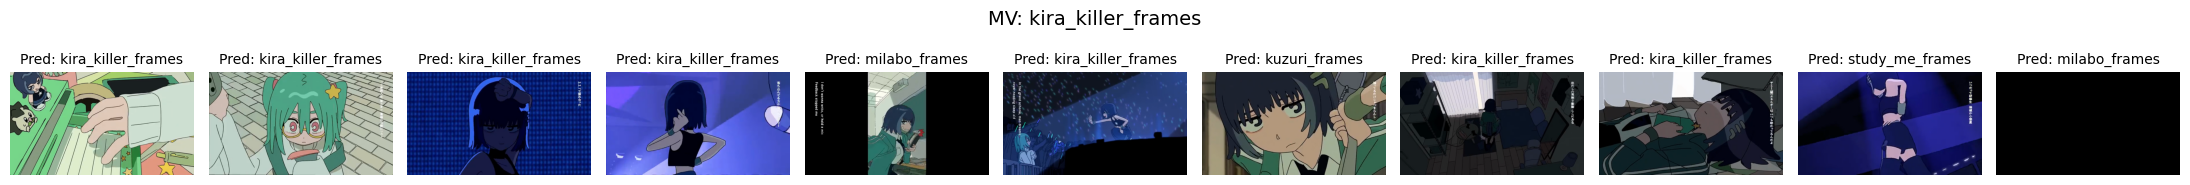

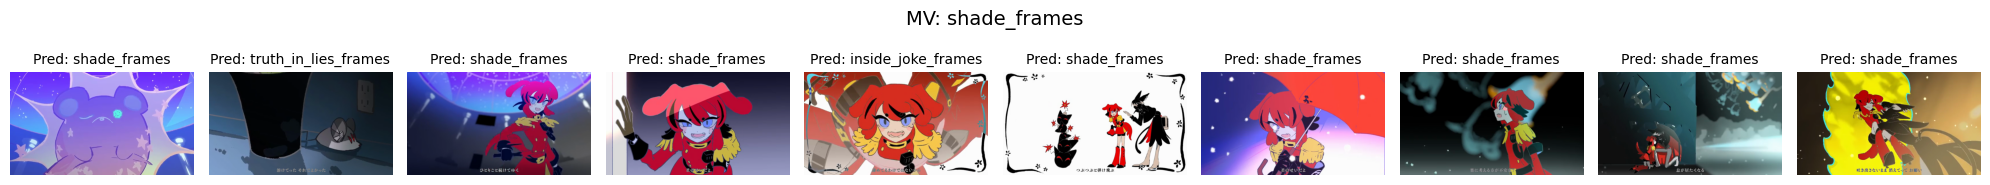

In [625]:
from collections import defaultdict
grouped = defaultdict(list)

print("Testing on unseen odd frames")

for true, pred, path in zip(y_true, y_pred, y_paths):
    grouped[true].append((path, pred))

for mv in frame_dirs:
    
    samples = grouped[mv]

    n = len(samples)
    plt.figure(figsize=(n * 2, 2))
    for i, (path, pred) in enumerate(samples):
        img = Image.open(path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"Pred: {pred}", fontsize=10)
        plt.axis('off')
    
    plt.suptitle(f"MV: {mv}", fontsize=14)
    plt.tight_layout()
    plt.show()
